In [8]:
import proplot as pplt
import numpy as np
import yaml
import glob
import copy

%matplotlib inline

In [9]:
import logging
import sys

import pizza_cutter

logging.basicConfig(stream=sys.stdout)
for code in ["ngmix", "metadetect", "pizza_cutter", "pizza_cutter_sims"]:
    logging.getLogger(code).setLevel(
        getattr(logging, "INFO"))

In [37]:
import tempfile
from pizza_cutter_sims.pizza_cutter import (
    run_des_pizza_cutter_coadding_on_sim,
    make_remapped_se_images_des_pizza_cutter_coadding_on_sim,
)
from pizza_cutter_sims.sim import generate_sim
from pizza_cutter_sims.constants import PIXEL_SCALE
from pizza_cutter_sims.mdet import run_metadetect, make_mbobs_from_coadd_data
from pizza_cutter_sims.sim import generate_sim
from pizza_cutter_sims.stars import mask_stars


cfg_yaml = """\
shear:
  scene: True

  # these keys are used to build paired sims w/ noise cancellation
  g: 0.02
  swap12: False

  # set these to run a sim directly
  g1: 0.02
  g2: 0.00

msk:
  cosmic_rays: True
  bad_columns: True
  streaks: True  

coadd:
  central_size: 225
  buffer_size: 25
  scale: 0.263

se:
  n_images: 3
  wcs_config:
    position_angle_range: [0, 0]
    dither_scale: 0  # set to an odd number of pixels
    scale: 0.263
    scale_frac_std: 0
    shear_std: 0

psf:
  type: galsim.Gaussian
  fwhm: 0.9
  fwhm_frac_std: 0.1
  shear_std: 0.1
  shear: [0, 0]

layout:
  type: hex
  ngal_per_side: 10
  ngal_per_arcmin2: 60
  dither_scale: 0.263

gal:
  type: exp-dim

star:
  dens_factor: 5
  rad_dist: uniform
  interp:
    skip: True
    # these control how the interpolation is applied for star holes
    # if fill_isolated_with_noise is True, then any missing pixel with no non-missing
    # pixels within iso_buff will be filled with noise and then used to interpolate
    # the rest of the pixels.
    iso_buff: 1
    fill_isolated_with_noise: False
  apodize:
    skip: False
    ap_rad: 1
  mask_expand_rad: 16

pizza_cutter:
  skip: False
  single_epoch_config:
    # pixel spacing for building various WCS interpolants
    se_wcs_interp_delta: 10
    coadd_wcs_interp_delta: 25
    frac_buffer: 1.42  # buffer around SE image to account for position angle rotations

    reject_outliers: False
    symmetrize_masking: True
    copy_masked_edges: False
    max_masked_fraction: 1.1
    edge_buffer: 8
    mask_tape_bumps: False

    # set the interp flags to 0 or 3 or 7 to interp stuff in the mask
    spline_interp_flags:
      - 7
    noise_interp_flags:
      - 0

    # always zero
    bad_image_flags:
      - 0

metadetect:
  metacal:
    psf: fitgauss
    types: [noshear, 1p, 1m, 2p, 2m]
    use_noise_image: True

  psf:
    lm_pars:
      maxfev: 2000
      ftol: 1.0e-05
      xtol: 1.0e-05
    model: gauss

    # we try many times because if this fails we get no psf info
    # for the entire patch
    ntry: 10

  sx:

  weight:
    fwhm: 1.2  # arcsec

  meds:
    box_padding: 2
    box_type: iso_radius
    max_box_size: 64
    min_box_size: 32
    rad_fac: 2
    rad_min: 4

  maskflags: 33554432  # 2**25 = BMASK_GAIA_STAR from pizza cutter

  # check for an edge hit
  bmask_flags: 1610612736  # 2**29 || 2**30
"""

cfg = yaml.safe_load(cfg_yaml)

In [41]:
import copy

mask_keys = ["cosmic_rays", "bad_columns", "streaks"]

all_data = {}
for key in mask_keys:
    _cfg = copy.deepcopy(cfg)
    
    for _key in mask_keys:
        if _key == key:
            _cfg["msk"][_key] = True
        else:
            _cfg["msk"][_key] = False
    
    rng = np.random.RandomState(seed=3143)
    seeds = rng.randint(low=1, high=2**29, size=5)

    rng = np.random.RandomState(seed=seeds[0])
    gal_rng = np.random.RandomState(seed=seeds[1])
    coadd_rng = np.random.RandomState(seed=seeds[2])
    mdet_rng = np.random.RandomState(seed=seeds[3])
    star_rng = np.random.RandomState(seed=seeds[4])

    print(_cfg["msk"])
    
    data = generate_sim(
        rng=rng,
        gal_rng=gal_rng,
        coadd_config=_cfg["coadd"],
        se_config=_cfg["se"],
        psf_config=_cfg["psf"],
        gal_config=_cfg["gal"],
        star_config=_cfg["star"],
        layout_config=_cfg["layout"],
        msk_config=_cfg["msk"],
        shear_config=_cfg["shear"],
        star_rng=star_rng,
        skip_coadding=False
    )
    all_data[key] = data

{'cosmic_rays': True, 'bad_columns': False, 'streaks': False}
{'cosmic_rays': False, 'bad_columns': True, 'streaks': False}
{'cosmic_rays': False, 'bad_columns': False, 'streaks': True}


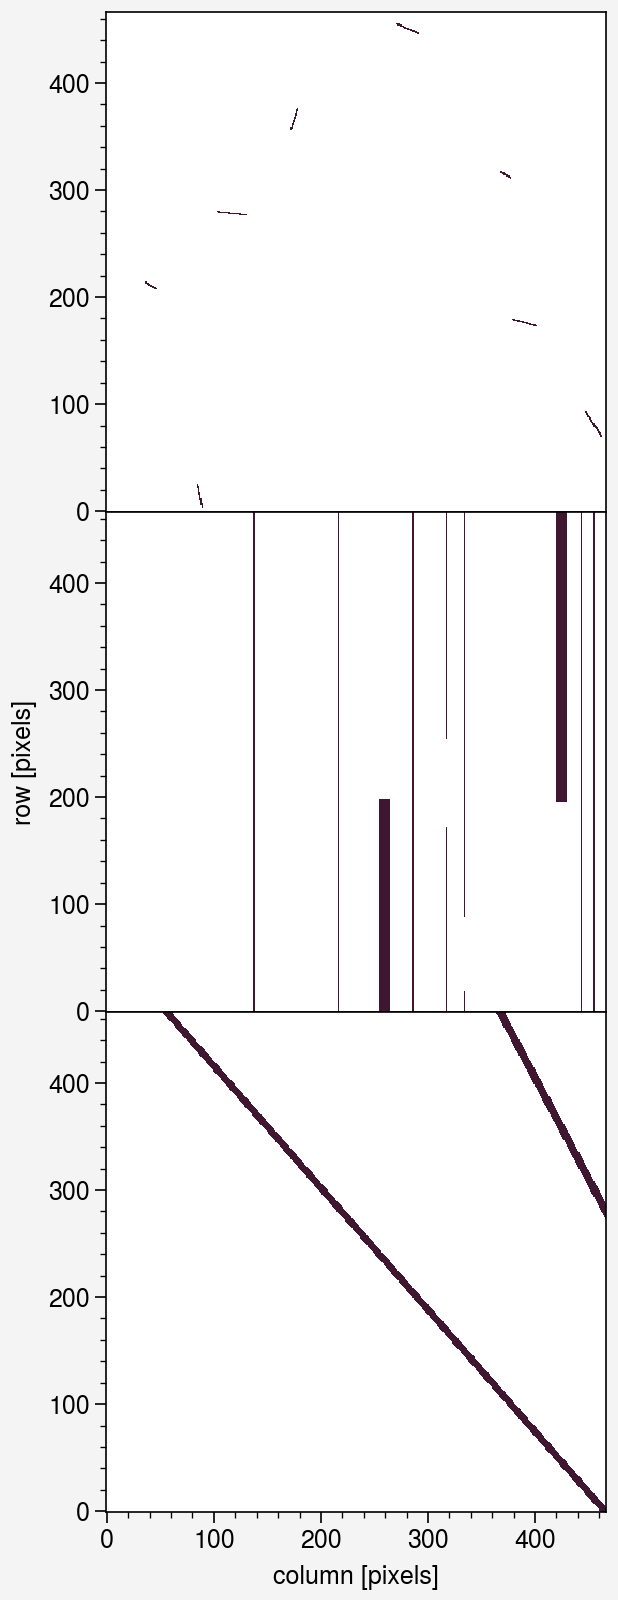

In [43]:
fig, axs = pplt.subplots(nrows=3, ncols=1, share=True, space=0)

for i, key in enumerate(mask_keys):
    ax = axs[i]
    
    ax.pcolormesh(all_data[key]["msk"][1])
    
axs.format(xlabel='column [pixels]', ylabel='row [pixels]')
fig.savefig("masking.png", dpi=200)